In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import datasets

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


## Importing the labeled faces dataset

In [70]:
dataset = datasets.fetch_lfw_people(download_if_missing=True)

images = dataset.images.astype('float32') / 255.
print(images.shape)
print(images[0].shape)
img_shape = images[0].shape;
pixels = img_shape[0] * img_shape[1]
print(pixels)

(13233, 62, 47)
(62, 47)
2914


## Visualizing images

In [197]:
def plotImages(original_imgs, rec_imgs = None, n = 10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original_imgs[i])
      plt.title("original")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if(rec_imgs is not None):
      # display reconstruction
          ax = plt.subplot(2, n, i + 1 + n)
          plt.imshow(rec_imgs[i])
          plt.title("reconstructed")
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
    plt.show()

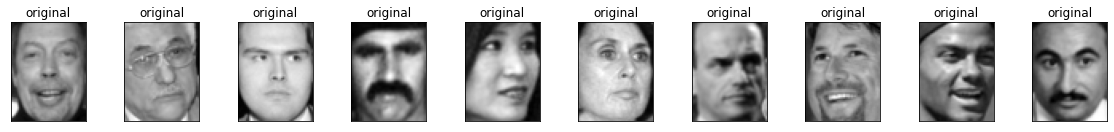

In [198]:
plotImages(dataset.images, n = 10)

## Training / Test split

In [56]:
x_train, x_test = train_test_split(
    images, test_size=0.2, random_state=12345, shuffle=True
)
print(x_train.shape)
print(x_test.shape)


(10586, 62, 47)
(2647, 62, 47)


## The basic autoencoder

In [146]:
latent_dim = 128 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(), # flatten image (62x47) to layer
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Input(shape = (latent_dim, )),
      layers.Dense(pixels, activation='sigmoid'),
      layers.Reshape(img_shape) # reverse flattening of image
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)


In [147]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [148]:
cb_earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    restore_best_weights=True,
)


autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[cb_earlyStopping])

Epoch 1/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0180 - val_loss: 0.0145
Epoch 2/50
662/662 [==============================] - 4s 5ms/step - loss: 0.0131 - val_loss: 0.0118
Epoch 3/50
662/662 [==============================] - 4s 5ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 4/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 5/50
662/662 [==============================] - 3s 5ms/step - loss: 0.0103 - val_loss: 0.0118
Epoch 6/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 7/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0095 - val_loss: 0.0092
Epoch 8/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 9/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 10/50
662/662 [==============================] - 4s 6ms/step - loss: 0.0087 - val_loss: 0.0085

In [156]:
autoencoder.encoder.summary()

autoencoder.decoder.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 2914)              0         
                                                                 
 dense_39 (Dense)            (None, 128)               373120    
                                                                 
Total params: 373,120
Trainable params: 373,120
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 2914)              375906    
                                                                 
 reshape_18 (Reshape)        (None, 62, 47)            0         
                                                                 
Total params: 375,906
Tr

In [200]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

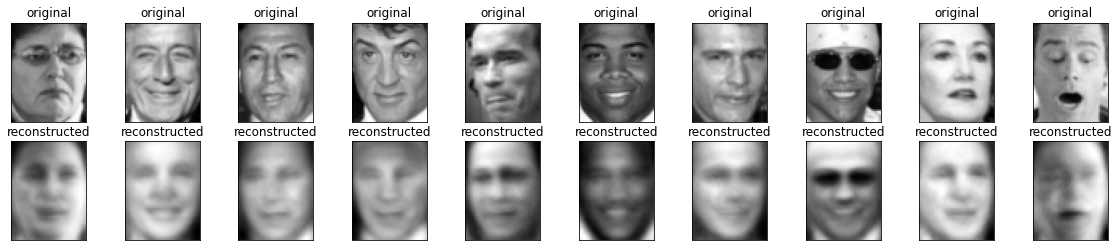

In [206]:
plotImages(x_test, decoded_imgs, n = 10)

## Generate an image

In [163]:
latent_code = np.arange(0.01, 0.01*(latent_dim+1), 0.01, dtype='float32')
latent_code_reshaped = latent_code[np.newaxis, ...] # reshape so that decoder doesn't complain
print(latent_code.shape)
print(latent_code_reshaped.shape)


(128,)
(1, 128)


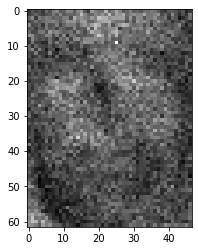

In [171]:
generated_imgs = autoencoder.decoder(latent_code_reshaped).numpy()
plt.imshow(generated_imgs[0])

### Feed generated image in encode-decode loop to see what happens 

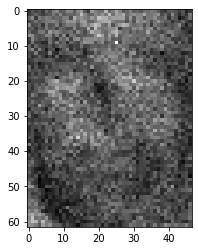

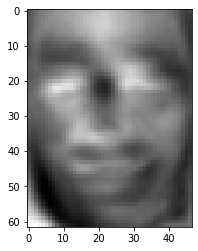

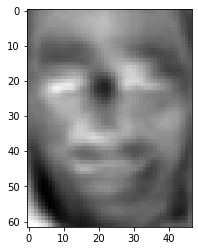

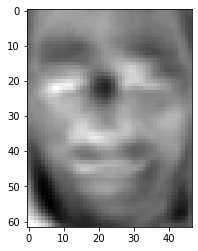

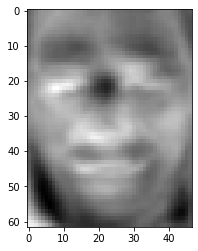

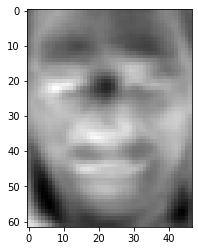

In [173]:
looped_imgs = generated_imgs
plt.figure()
plt.imshow(looped_imgs[0])
plt.show()
for x in range(5):
    looped_imgs = autoencoder.encoder(looped_imgs).numpy()
    looped_imgs = autoencoder.decoder(looped_imgs).numpy()
    plt.figure()
    plt.imshow(looped_imgs[0])
    plt.show()

## Denoiser

In [234]:
x_train, x_test = train_test_split(
    images, test_size=0.2, random_state=12345, shuffle=True
)
print(x_train.shape)
print(x_test.shape)


(10586, 62, 47)
(2647, 62, 47)


In [235]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


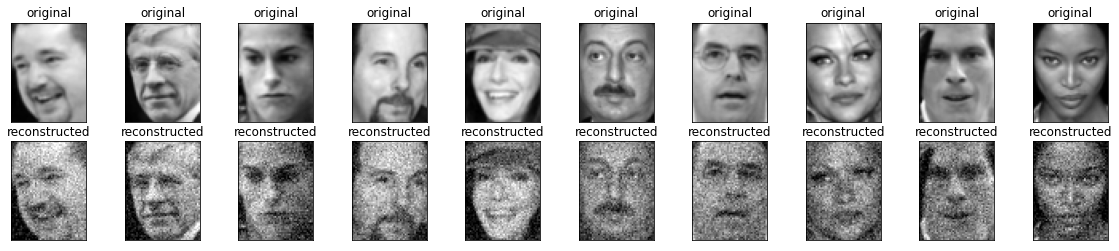

In [236]:
plotImages(x_train, x_train_noisy, 10)

## Denoiser

In [241]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(62, 47, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

denoiseAutoencoder = Denoise()


In [242]:
denoiseAutoencoder.compile(optimizer='adam', loss='mae')


In [243]:

print(x_train_noisy.shape)
print(x_train.shape)
print(x_test_noisy.shape)
print(x_test.shape)


denoiseAutoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


(10586, 62, 47)
(10586, 62, 47)
(2647, 62, 47)
(2647, 62, 47)
Epoch 1/10


ValueError: in user code:

    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 919, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "D:\Anaconda\envs\deeplearning\lib\site-packages\keras\losses.py", line 1457, in mean_absolute_error
        return backend.mean(tf.abs(y_pred - y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 64 and 62 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](mean_absolute_error/remove_squeezable_dimensions/Squeeze, IteratorGetNext:1)' with input shapes: [?,64,48], [?,62,47].
